In [35]:
import numpy as np
from tqdm import tqdm

import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchkeras.tabular import TabularPreprocessor, TabularDataset
from torchkeras.tabular.models import FTTransformerConfig, FTTransformerModel

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report

In [2]:
np.random.seed(42)
train_df = pd.read_csv("data/train_df.csv")

In [3]:
train_df.head()

,age,gender,primary_diagnosis,num_procedures,days_in_hospital,comorbidity_score,discharge_to,readmitted
0,69,Male,Heart Disease,1,2,1,Home Health Care,0
1,32,Female,COPD,2,13,2,Rehabilitation Facility,0
2,89,Male,Diabetes,1,7,1,Home,0
3,78,Male,COPD,9,2,2,Skilled Nursing Facility,0
4,38,Male,Diabetes,6,4,4,Rehabilitation Facility,0


In [4]:
# ----- 數值型與類別型特徵 -----
numerical_features = ['age', 'num_procedures', 'days_in_hospital', 'comorbidity_score']
categorical_features = ['gender', 'primary_diagnosis', 'discharge_to']
target = 'readmitted'

In [62]:
df = train_df.copy()

# 前處理

In [8]:
# 數值標準化
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# 將類別特徵轉為 category 類型
for col in categorical_features:
    df[col] = df[col].astype('category')

df[target] = df[target].astype('category')

# 轉成 numpy
X_num = df[numerical_features].values.astype(np.float32)
X_cat = df[categorical_features].values
y = df[target].values.astype(np.int64)

# 分割訓練測試資料
X_num_train, X_num_test, X_cat_train, X_cat_test, y_train, y_test = train_test_split(
    X_num, X_cat, y, test_size=0.2, random_state=42
)

In [63]:
# 1. 將數據轉為 DataFrame 格式，因為 TabularPreprocessor 通常需要 DataFrame
numerical_columns = [f'num_{i}' for i in range(len(numerical_features))]
categorical_columns = [f'cat_{i}' for i in range(len(categorical_features))]

train_df_train_csv = pd.DataFrame({
    **{f'num_{i}': X_num_train[:, i] for i in range(X_num_train.shape[1])},
    **{f'cat_{i}': X_cat_train[:, i] for i in range(X_cat_train.shape[1])},
    'target': y_train
})

test_df_train_csv = pd.DataFrame({
    **{f'num_{i}': X_num_test[:, i] for i in range(X_num_test.shape[1])},
    **{f'cat_{i}': X_cat_test[:, i] for i in range(X_cat_test.shape[1])},
    'target': y_test
})

In [64]:
train_df_train_csv.head()

,num_0,num_1,num_2,num_3,cat_0,cat_1,cat_2,target
0,0.954285,0.879834,0.646778,-0.751363,Male,Hypertension,Home Health Care,0
1,-0.014483,-0.159749,1.143649,-0.048235,Female,COPD,Home Health Care,1
2,-0.062921,-0.852805,-1.589145,-0.048235,Female,Heart Disease,Home,1
3,-0.208237,-0.852805,-0.346965,-0.751363,Male,Heart Disease,Home,0
4,-0.644182,1.572889,-0.346965,0.654894,Male,COPD,Home Health Care,0


In [65]:
train_target_df = train_df_train_csv['target']
train_df_train_csv = train_df_train_csv.drop(columns=['target'])
test_target_df = test_df_train_csv['target']
test_df_train_csv = test_df_train_csv.drop(columns=['target'])

# 使用 TabularPreprocessor 進行預處理
preprocessor = TabularPreprocessor(
    cat_features=categorical_columns,  # 類別特徵
    numeric_features=numerical_columns,    # 數值特徵
    normalization='standard',           # 數值特徵標準化（可選：'minmax' 或 None）
    onehot_max_cat_num=1,
)

preprocessor.fit(train_df_train_csv)
train_df_train_csv_processed = preprocessor.transform(train_df_train_csv)
test_df_train_csv_processed = preprocessor.transform(test_df_train_csv)

100%|██████████| 3/3 [00:00<00:00, 1173.89it/s]
c:\Users\ShiShiuan\Desktop\機器學習與人工智慧實作\venv\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\ShiShiuan\Desktop\機器學習與人工智慧實作\venv\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\ShiShiuan\Desktop\機器學習與人工智慧實作\venv\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  w

In [68]:
train_df_train_csv_processed = train_df_train_csv_processed.loc[:, ~train_df_train_csv_processed.columns.duplicated(keep='last')]
test_df_train_csv_processed = test_df_train_csv_processed.loc[:, ~test_df_train_csv_processed.columns.duplicated(keep='last')]

numerical_features = preprocessor.get_numeric_features()
embedding_features = preprocessor.get_embedding_features()


In [69]:
train_df_train_csv_processed['target'] = train_target_df
test_df_train_csv_processed['target'] = test_target_df

# === 3. 建立 TabularDataset ===
ds_train = TabularDataset(
    data=train_df_train_csv_processed,
    task='classification',
    target=['target'],
    continuous_cols=numerical_features,
    categorical_cols=embedding_features
)

ds_test = TabularDataset(
    data=test_df_train_csv_processed,
    task='classification',
    target=['target'],
    continuous_cols=numerical_features,
    categorical_cols=embedding_features
)

dl_train = DataLoader(ds_train, batch_size=128, shuffle=False, num_workers=0, pin_memory=False)

dl_test = DataLoader(ds_test, batch_size=128, shuffle=False, num_workers=0, pin_memory=False)

In [82]:
print("categorical features (cols):", embedding_features)
print("categorical features (array):", train_df_train_csv_processed[embedding_features].shape[1])

print("numerical features (cols):", numerical_features)
print("numerical features (array):", train_df_train_csv_processed[numerical_features].shape[1])

categorical features (cols): ['cat_0', 'cat_1', 'cat_2']
categorical features (array): 3
numerical features (cols): ['num_0', 'num_1', 'num_2', 'num_3']
numerical features (array): 4


# 建立模型

In [72]:
model_config = FTTransformerConfig(
    # ModelConfig 參數
    task="classification",  # 二元分類
    num_attn_blocks=3,
)

config = model_config.merge_dataset_config(ds_train)

In [73]:
# 11. 初始化模型
model = FTTransformerModel(config)

# 訓練模型

In [74]:
# 12. 設置優化器和損失函數
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

In [75]:
# 訓練模型
def train_model(model: FTTransformerModel, train_loader: DataLoader, criterion: torch.nn.CrossEntropyLoss, optimizer: torch.optim.Adam, num_epochs:int=20, device:str=device):
    model.to(device)
    model.train()

    progress_bar = tqdm(range(num_epochs), leave=False)
    for epoch in progress_bar:
        total_loss = 0
        for batch in train_loader:
            numerical = batch['continuous'].to(device)
            categorical = batch['categorical'].to(device)
            target = batch['target'].to(device).squeeze()
            optimizer.zero_grad()
            outputs = model({'continuous': numerical, 'categorical': categorical})
            logits = outputs['logits']
            loss = criterion(logits, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs} | Avg. Loss: {total_loss/len(train_loader):.4f}")
    
    # 儲存模型（建議用 .pt 或 .pth）
    torch.save(model.state_dict(), 'ft_transformer_model.pth')


# 16. 評估模型
def evaluate_model(model, test_loader, device=device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in test_loader:
            numerical = batch['continuous'].to(device)
            categorical = batch['categorical'].to(device)
            target = batch['target'].to(device).squeeze()
            outputs = model({'continuous': numerical, 'categorical': categorical})
            _, preds = torch.max(outputs['logits'], dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(target.cpu().numpy())
    accuracy = accuracy_score(true_labels, predictions)
    print(f'Test Accuracy: {accuracy:.4f}')
    print('\nClassification Report:')
    print(classification_report(true_labels, predictions))

# 17. 執行訓練和評估
train_model(model, dl_train, criterion, optimizer, num_epochs=100)
evaluate_model(model, dl_test)

Test Accuracy: 0.7020

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       826
           1       0.16      0.16      0.16       174

    accuracy                           0.70      1000
   macro avg       0.49      0.49      0.49      1000
weighted avg       0.71      0.70      0.70      1000



# 測試集

In [76]:
test_df_test_csv = pd.read_csv("data/test_df.csv")

test_numerical_features = ['age', 'num_procedures', 'days_in_hospital', 'comorbidity_score']
test_categorical_features = ['gender', 'primary_diagnosis', 'discharge_to']

# 將類別特徵轉為 category 類型
for col in test_categorical_features:
    test_df_test_csv[col] = test_df_test_csv[col].astype('category')

In [77]:
X_num_test_csv = test_df_test_csv[test_numerical_features].values.astype(np.float32)
X_cat_test_csv = test_df_test_csv[test_categorical_features].values

In [78]:
test_df_test_csv = pd.DataFrame({
    **{f'num_{i}': X_num_test_csv[:, i] for i in range(X_num_test_csv.shape[1])},
    **{f'cat_{i}': X_cat_test_csv[:, i] for i in range(X_cat_test_csv.shape[1])},
})

In [90]:
len(test_df_test_csv)

2000

In [84]:
test_df_test_csv_processed = preprocessor.transform(test_df_test_csv)
test_df_test_csv_processed = test_df_test_csv_processed.loc[:, ~test_df_test_csv_processed.columns.duplicated(keep='last')]

ds_test_test_csv = TabularDataset(
    data=test_df_test_csv_processed,
    task='classification',
    continuous_cols=numerical_features,
    categorical_cols=embedding_features
)

dl_test_test_csv = DataLoader(ds_test_test_csv, batch_size=128, shuffle=False, num_workers=0, pin_memory=False)

c:\Users\ShiShiuan\Desktop\機器學習與人工智慧實作\venv\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\ShiShiuan\Desktop\機器學習與人工智慧實作\venv\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [85]:
print("categorical features (cols):", embedding_features)
print("categorical features (array):", test_df_test_csv_processed[embedding_features].shape[1])

print("numerical features (cols):", numerical_features)
print("numerical features (array):", test_df_test_csv_processed[numerical_features].shape[1])

categorical features (cols): ['cat_0', 'cat_1', 'cat_2']
categorical features (array): 3
numerical features (cols): ['num_0', 'num_1', 'num_2', 'num_3']
numerical features (array): 4


In [101]:
# 12. 設置優化器和損失函數
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

# 初始化模型
model = FTTransformerModel(config=config)
model.load_state_dict(torch.load("ft_transformer_model.pth"))
model.to(device)

predictions = []
true_labels = []
# evaluation mode
model.eval()
with torch.no_grad():
    for batch in dl_test_test_csv:
        numerical = batch['continuous'].to(device)
        categorical = batch['categorical'].to(device)
        outputs = model({'continuous': numerical, 'categorical': categorical})
        _, preds = torch.max(outputs['logits'], dim=1)
        predictions.extend(preds.cpu().numpy())

submission_df = pd.DataFrame({
    "Patient_ID": range(1, len(predictions)+1),
    "readmitted": predictions
})

submission_df.to_csv(path_or_buf='data/submission_df.csv', index=False)


C:\Users\ShiShiuan\AppData\Local\Temp\ipykernel_20464\4276438963.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ft_transformer_model.p

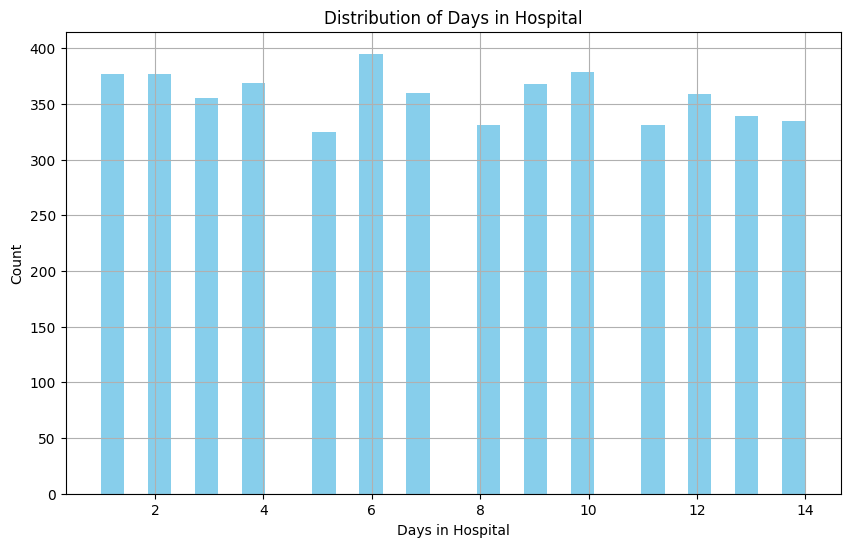

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(train_df['days_in_hospital'], bins=30, color='skyblue')
plt.title('Distribution of Days in Hospital')
plt.xlabel('Days in Hospital')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [18]:
train_df.describe()

,age,num_procedures,days_in_hospital,comorbidity_score,readmitted
count,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,53.299000,4.46100,7.396600,2.068600,0.188000
std,20.646851,2.88606,4.025587,1.422357,0.390751
min,18.000000,0.00000,1.000000,0.000000,0.000000
25%,36.000000,2.00000,4.000000,1.000000,0.000000
50%,53.000000,4.00000,7.000000,2.000000,0.000000
75%,71.000000,7.00000,11.000000,3.000000,0.000000
max,89.000000,9.00000,14.000000,4.000000,1.000000


In [24]:
y_columns = ['readmitted']
y = train_df[y_columns]

X_columns = train_df.columns.difference(y_columns)
X= train_df[X_columns]

# 假設 train_df 是原始 DataFrame（含 X, y）
# 分出數值型與類別型欄位
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

In [25]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.preprocessing import MinMaxScaler

# 處理數值型欄位
X_num = X[numeric_cols]
selector_num = SelectKBest(score_func=f_classif, k='all')
selector_num.fit(X_num, y)
scores_num = pd.Series(selector_num.scores_, index=numeric_cols)

# 處理類別型欄位（先 one-hot）
X_cat = pd.get_dummies(X[categorical_cols], drop_first=True)
# chi2 要求所有值為非負，因此要先做 MinMaxScaler
X_cat_scaled = MinMaxScaler().fit_transform(X_cat)
selector_cat = SelectKBest(score_func=chi2, k='all')
selector_cat.fit(X_cat_scaled, y)
scores_cat = pd.Series(selector_cat.scores_, index=X_cat.columns)

/Users/hank.tsai/Downloads/archive/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
scores_num

age                  0.012958
comorbidity_score    0.007859
days_in_hospital     0.476848
num_procedures       0.037006
dtype: float64

In [30]:
scores_cat

discharge_to_Home Health Care            0.259213
discharge_to_Rehabilitation Facility     0.063931
discharge_to_Skilled Nursing Facility    1.626527
gender_Male                              0.628461
primary_diagnosis_Diabetes               0.298190
primary_diagnosis_Heart Disease          0.218989
primary_diagnosis_Hypertension           0.651709
primary_diagnosis_Kidney Disease         0.825426
dtype: float64

In [27]:
# 合併所有欄位分數
all_scores = pd.concat([scores_num, scores_cat])
top_features = all_scores.sort_values(ascending=False).head(10).index.tolist()

# 選擇 top 特徵
X_selected = pd.concat([X_num, X_cat], axis=1)[top_features]